In [1]:
import sys
sys.path.insert(0, f'D:/OneDrive/Program/GitHub/EasyIDP')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

from easyric.caas_lite import TiffSpliter

In [2]:
project_name = 'broccoli_tanashi_5_20200417_mavicRGB_15m_M'
project_path = f"Z:/共享云端硬盘/broccoliProject/01_tanashi_broccoli2020_RGB_AP/{project_name}"
raw_img_folder=f"Z:/共享云端硬盘/broccoliProject/00_rgb_raw/{project_name}"
param_folder = f"{project_path}/params"

out_folder = f"Z:/共享云端硬盘/broccoliProject/10_anotation_use/png/{project_name}"
json_name = f"{out_folder}.json"

In [3]:
p4d = Pix4D(project_path=project_path, 
            raw_img_path=raw_img_folder, 
            project_name=project_name,
            param_folder=param_folder)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


# Texture classifier

In [4]:
import skimage

from skimage.io import imsave, imread
from skimage.morphology import square, ball
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray

from lt_classifier import training_data_generate, train_model, predict_model, save_result, accuracy_assessment

In [5]:
fore = imread(r'Z:\共享云端硬盘\broccoliProject\10_locate_by_cv\training_data\fore0417_mavic.png')
back = imread(r'Z:\共享云端硬盘\broccoliProject\10_locate_by_cv\training_data\back0417_mavic_grass.png')

In [6]:
def train_classifier(fore, back, mode="CART"):

    train_img_list = [back, fore]
    train_img_kinds = [0,1]
    train_data, train_kind = training_data_generate(train_img_list, train_img_kinds)
    cart_clf = train_model(train_data, train_kind, classifier=mode)

    return cart_clf

In [7]:
cart_clf = train_classifier(fore, back, mode="CART")

|--- Convert kind [0] to training data, converted shape is (563848, 13)
|--- Convert kind [1] to training data, converted shape is (10166, 13)
|-- Training model time cost=3s


In [9]:
test1 = imread(os.path.join(out_folder, 'grid_x04_y06.png'))

In [10]:
result1 = predict_model(test1, cart_clf)

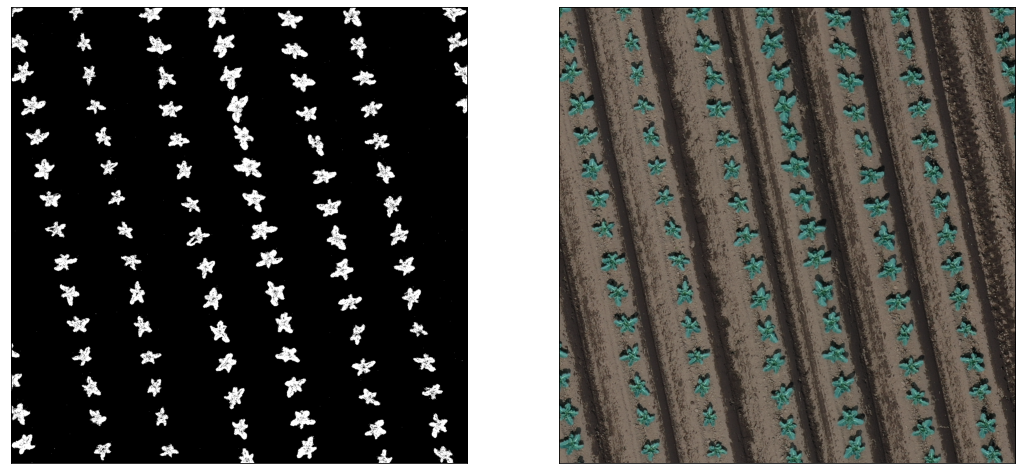

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 9))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(result1,cmap="gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(test1)

# batch processing

In [13]:
import os
import json
import pandas as pd
import matplotlib.patches as mpatches
label_folder = f"Z:/共享云端硬盘/broccoliProject/10_locate_by_cv/color_label_0417_mavic"

In [21]:
method = "Texture_CART"
img_out_folder = os.path.join(label_folder, method)
if not os.path.exists(img_out_folder):
    os.mkdir(img_out_folder)

In [15]:
with open(os.path.join(out_folder, json_name), 'r') as f:
    offset_dict = json.load(f)

In [24]:
bbox = pd.DataFrame(columns=['offset_x', 'offset_y', 'xc', 'yc', 'x0', 'y0', 'x1', 'y1', 'w', 'h', 'area'])

total = len(os.listdir(out_folder))
count = 0

for grid_name in os.listdir(out_folder):
    off = offset_dict[grid_name.replace('png', 'tif')]
    off_x, off_y = off['x'], off['y']
    
    count += 1
    img_full_path = os.path.join(out_folder, grid_name)
    img_array = imread(img_full_path)
    
    img_binary = predict_model(img_array, cart_clf)
    img_binary= skimage.morphology.closing(img_binary, square(5))
    #img_binary = skimage.morphology.remove_small_objects(img_binary, min_size=50)
    #img_binary = skimage.morphology.remove_small_holes(img_binary.astype(bool), area_threshold=50)
    
    img_label = label(img_binary)
    
    label_id, label_count = np.unique(img_label, return_counts=True)
    
    for remove_id in label_id[label_count > 7000]:
        if remove_id != 0:
            img_label[img_label==remove_id] = 0
    
    image_label_overlay = label2rgb(img_label, image=img_array, bg_label=0)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_label_overlay)
    
    x_list, y_list = [], []
    for region in regionprops(img_label):
        if region.area < 100:
            continue
            
        minr, minc, maxr, maxc = region.bbox

        height = maxc-minc
        width = maxr-minr
        
        xc = (minc + maxc) / 2
        yc = (minr + maxr) / 2

        x_list.append(xc)
        y_list.append(yc)

        if height > 20 and width > 20:
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            
        container = {'offset_x': off_x, 'offset_y':off_y, 
                     'xc':xc, 'yc':yc, 
                     'x0':minc, 'y0':minr, 'x1':maxc, 'y1':maxr, 
                     'w':width, 'h':height, 'area':region.area}
        
        bbox.loc[len(bbox),:] = container
        
    ax.scatter(x_list, y_list, c='r', alpha=0.7)
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(os.path.join(label_folder, method, grid_name))
    
    plt.clf()
    plt.cla()
    plt.close(fig)
    del img_array, img_binary, image_label_overlay
    
    print(round(count / total * 100), end='\r')
    
bbox.to_csv(os.path.join(label_folder, method, 'bbox.csv'))